## CNN  en sepecifier une station

In [ ]:
from tensorflow.keras import  layers , callbacks,optimizers,models
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler






## CNN  pour toute stations

In [25]:
file_path = 'merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
# prepa de data, add time categorie
data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['minute'] = data['timestamp'].dt.minute
data['date'] = data['timestamp'].dt.date          
data = data.drop(columns=['timestamp'])
print(data.columns.tolist())

# traite data train test

standardScale_feature=['visibility_distance','current_temperature','feels_like_temperature','wind_speed','counter_events']
inchange_feature=['date','minute','hour','day_of_week','is_weekend','is_rainy','number','status']


data_y=data['available_bikes']
data_x=data.drop(columns=['available_bikes', 'available_bike_stands'])

scaler_x = StandardScaler()
scaler_y = MinMaxScaler()
data_x_scaled = data_x.copy()
data_x_scaled[standardScale_feature]=scaler_x.fit_transform(data_x[standardScale_feature])
data_y_scaled =scaler_y.fit_transform(data_y.values.reshape(-1, 1))

data_scaled = pd.concat([data_x_scaled, pd.DataFrame(data_y_scaled, columns=['available_bikes'], index=data.index)], axis=1)

## test split :
grouped = data_scaled.groupby('number') 

train_data = []
test_data = []

test_ratio = 0.2 

for station, group in grouped:
    group=group.sort_index()
    train_size = int(len(group) * (1 - test_ratio)) 
    train_data.append(group.iloc[:train_size])  
    test_data.append(group.iloc[train_size:])
  


train_data = pd.concat(train_data)
test_data = pd.concat(test_data)
print(train_data.columns.to_list())
print(test_data.columns.to_list())

['number', 'status', 'available_bike_stands', 'available_bikes', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'snow', 'wind_speed', 'counter_events', 'hour', 'day_of_week', 'is_weekend', 'minute', 'date']
['number', 'status', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'snow', 'wind_speed', 'counter_events', 'hour', 'day_of_week', 'is_weekend', 'minute', 'date', 'available_bikes']
['number', 'status', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'snow', 'wind_speed', 'counter_events', 'hour', 'day_of_week', 'is_weekend', 'minute', 'date', 'available_bikes']


In [18]:

X_train = train_data.drop(columns=['available_bikes'])
y_train = train_data['available_bikes']

X_test = test_data.drop(columns=['available_bikes'])
y_test = test_data['available_bikes']

X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = y_train.values
y_test = y_test.values
print(f"Total unique stations in data: {data['number'].nunique()}")
print("x_train shape: ")
print(X_train.shape)
print("y_train shape: ")
print(y_train.shape)
print("x_test shape: ")
print(X_test.shape)
print("y_test shape: ")
print(y_test.shape)
print(grouped.get_group(1).describe())


Total unique stations in data: 382
x_train shape: 
(945227, 1, 12)
y_train shape: 
(945227,)
x_test shape: 
(236592, 1, 12)
y_test shape: 
(236592,)
       number  status  visibility_distance  current_temperature  \
count  3102.0  3102.0          3102.000000          3102.000000   
mean      1.0     1.0            -0.000003            -0.000093   
std       0.0     0.0             1.000147             1.000265   
min       1.0     1.0            -2.678301            -2.975013   
25%       1.0     1.0            -0.125373            -0.708127   
50%       1.0     1.0             0.537725             0.047502   
75%       1.0     1.0             0.537725             0.677193   
max       1.0     1.0             0.537725             2.818141   

       feels_like_temperature     is_rainy    snow   wind_speed  \
count             3102.000000  3102.000000  3102.0  3102.000000   
mean                -0.000085     0.116215     0.0    -0.000026   
std                  1.000242     0.295813    

In [19]:
model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=1, padding='causal',activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    layers.Conv1D(
            filters=64,
            kernel_size=2,
            padding='causal',
            activation='relu'
        ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')  
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 16)             208       
                                                                 
 batch_normalization (Batch  (None, 1, 16)             64        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             2112      
                                                                 
 batch_normalization_1 (Bat  (None, 1, 64)             256       
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [20]:
print("Training the model...")
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=128,
    shuffle=False,
    callbacks=[callbacks] 
)



Training the model...
Epoch 1/30
6647/6647 [==============================] - 105s 15ms/step - loss: 0.0126 - mae: 0.0863 - val_loss: 0.0393 - val_mae: 0.1128 - lr: 0.0010
Epoch 2/30
6647/6647 [==============================] - 55s 8ms/step - loss: 0.0113 - mae: 0.0847 - val_loss: 0.0075 - val_mae: 0.0713 - lr: 0.0010
Epoch 3/30
6647/6647 [==============================] - 74s 11ms/step - loss: 0.0115 - mae: 0.0855 - val_loss: 0.0076 - val_mae: 0.0733 - lr: 0.0010
Epoch 4/30
6647/6647 [==============================] - 81s 12ms/step - loss: 0.0115 - mae: 0.0855 - val_loss: 0.0081 - val_mae: 0.0757 - lr: 0.0010
Epoch 5/30
6647/6647 [==============================] - 197s 30ms/step - loss: 0.0115 - mae: 0.0858 - val_loss: 0.0089 - val_mae: 0.0768 - lr: 5.0000e-04


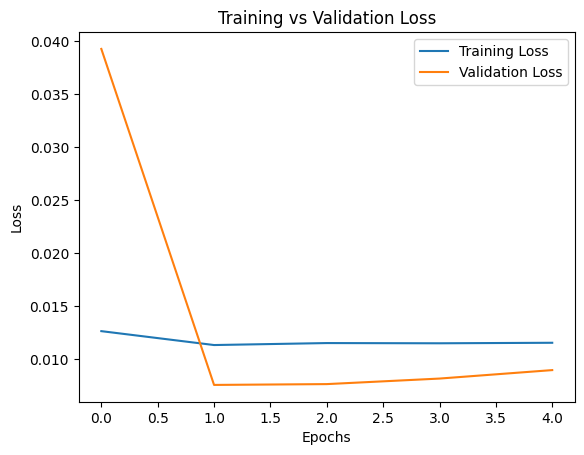

In [21]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [22]:
predictions = model.predict( X_test)
r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

7394/7394 [==============================] - 31s 4ms/step
R² Score: -1.5594736702868461


LSTM

train shape: (911737, 4, 15)
test shape: (227076, 4, 15)
Epoch 1/30
11397/11397 [==============================] - 347s 29ms/step - loss: 0.0077 - mae: 0.0592 - val_loss: 0.0053 - val_mae: 0.0593 - lr: 0.0010
Epoch 2/30
11397/11397 [==============================] - 275s 24ms/step - loss: 0.0041 - mae: 0.0477 - val_loss: 0.0023 - val_mae: 0.0368 - lr: 0.0010
Epoch 3/30
11397/11397 [==============================] - 250s 22ms/step - loss: 0.0037 - mae: 0.0445 - val_loss: 0.0028 - val_mae: 0.0427 - lr: 0.0010
Epoch 4/30
11397/11397 [==============================] - 250s 22ms/step - loss: 0.0034 - mae: 0.0429 - val_loss: 0.0030 - val_mae: 0.0435 - lr: 0.0010
Epoch 5/30
11397/11397 [==============================] - 315s 28ms/step - loss: 0.0033 - mae: 0.0422 - val_loss: 0.0024 - val_mae: 0.0370 - lr: 0.0010
Epoch 6/30
11397/11397 [==============================] - 325s 28ms/step - loss: 0.0033 - mae: 0.0420 - val_loss: 0.0032 - val_mae: 0.0431 - lr: 5.0000e-04
Epoch 7/30
11397/11397 [===

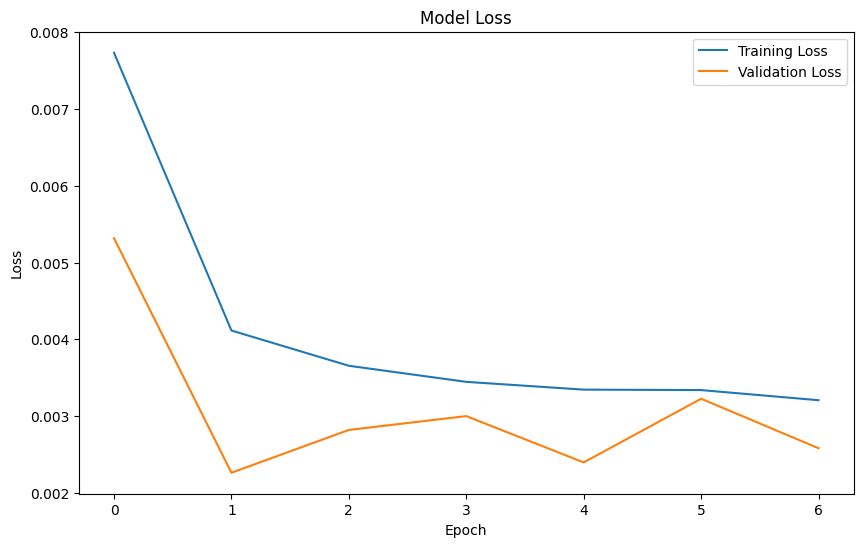

7097/7097 [==============================] - 57s 8ms/step

Model Performance:
R² Score: -0.9638
MAE: 0.1052


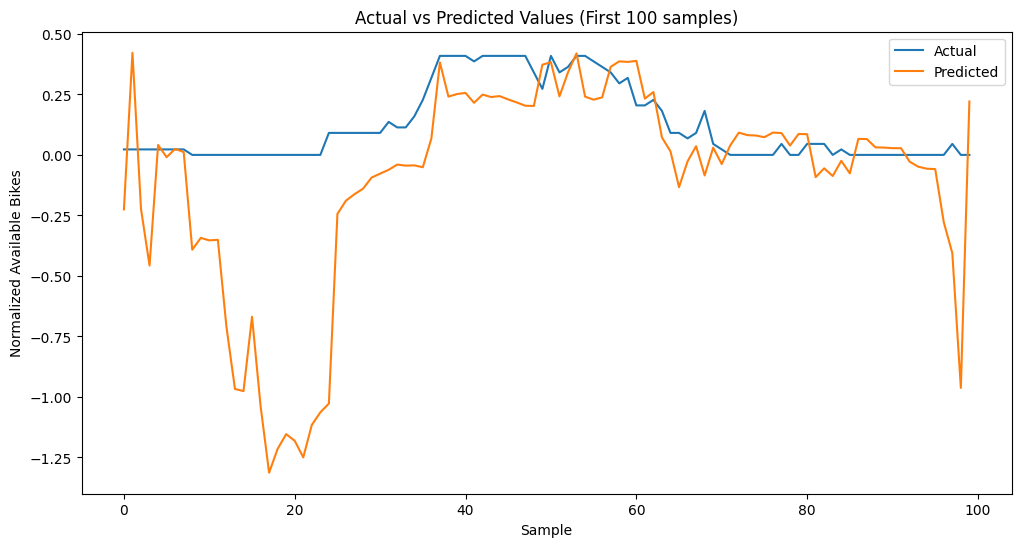

In [15]:
def create_sequences(data, window_size, target_col='available_bikes'):
    X = []
    y = []
    grouped = data.groupby('number')
    
    for _, group in grouped:
        group = group.sort_index()
        sequences = []
        targets = []
        
        for i in range(len(group) - window_size):
            sequences.append(group.iloc[i:i + window_size].values)
            targets.append(group.iloc[i + window_size][target_col])
            
        X.extend(sequences)
        y.extend(targets)
    
    return np.array(X), np.array(y)
X_train, y_train = create_sequences(train_data, 4)
X_test, y_test = create_sequences(test_data, 4)
print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    layers.LSTM(32),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=callbacks_list,
        shuffle=False
    )

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'\nModel Performance:')
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()